#  Geolocation

- formulation of a solver.

- statistical simulations in order to determine sources of uncertainty

---

# 1 - Formulation

<img src='schematic.jpeg' alt='Drawing' align='right' style='width: 300px;'/>

We want to find the float horizontal position $\underline{x}=(x,y)$ of an underwater float 
given a number of **known variables**:
- $\underline{x}_s^i$ : source surface float horizontal position
- $t_e^i$ : time of emission for source $i$
- $\tilde{t}_r^i$ : time of reception of the signal emitted by source $i$ by the underwater float
- $\epsilon_i$ : signal detection, $\epsilon_i=1$ (detection) or $1$ (no detection)
- $z$ : underwater float depth(perfect knowledge), not used for now

'Perfect' knowledge is assumed for known variables wich amounts to say potential errors on there
estimates may be neglected.

---
**Unknown variables** are:
- $\underline{x}=(x,y)$ : underwater float position
- $\delta t$ : underwater float clock offset, $\delta t = \tilde{t}_r^i - t_r^i$, where 
$t_r^i$ is the true time of reception
- $\delta \underline{x}^i$ : vector difference between source $i$ transducer position and surface float position, $\delta \underline{x}^i = \underline{x}_t^i - \underline{x}_s^i$
- $\delta t_p (\underline{x},\underline{x}_t^i)$ : difference between actual $(t_r^i - t_e^i)$ and an priori time $t_p(\underline{x},\underline{x}_t^i)$ of propagation between $\underline{x}$ and $\underline{x}_t^i$.

For simplicity, we assume the assumed propagation time is a function of range only: $t_p(\underline{x},\underline{x}_t^i) = t_p(|| \underline{x} - \underline{x}_t^i ||)$.

$t_p$ may for example be given by an a priori estimate of velocity ($c_b$) along with a measure of velocity uncertainty ($e_c$). In this case, we expect the error on time to grow with range according to: $e_{tp} \propto || \underline{x}_b - \underline{x}_t^i || /e_c$, where $\underline{x}_b$ is an a priori estimate for the float location.

A priori standard deviations for $\underline{x}$, $\delta \underline{x}^i$, $\delta t_p  (\underline{x},\underline{x}_t^i)$ are
assumed to be known and given by: $e_x$, $e_{\delta x}$, $e_{tp}$.

Background (a priori) estimates for $\underline{x}$, $\delta \underline{x}^i$, $\delta t_p (\underline{x},\underline{x}_t^i)$ may eventually be provided. We assume all are 0 for now except
for the float position $\underline{x}_b=(x=1km, y=0km)$.


---
The estimate of the underwater float position $\underline{\hat{x}}$ minimizes:

$$
\begin{align*}
J(\mathbf{x}, \delta t) &= 
||\underline{x} - \underline{x}_b||^2 /e_x^2 
+ \sum_i \epsilon_i \times  \delta t (\underline{x},\underline{x}_t^i)^2 / e_{tp}^2 \\
&= 
||\underline{x} - \underline{x}_b||^2 /e_x^2
+ \sum_i \epsilon_i \times \big [ \tilde{t}_r^i + \delta t  - t_e^i  -  t_p(\underline{x},\underline{x}_t^i) \big ]^2 / e_{tp}^2
\end{align*}
$$

We assume $\epsilon_i=1$ in all examples below for simplicity.

We have assumed simultaneous (working assumption) emission of sources.
The underwater float velocity may be added as an extra variable (future addition).

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt

from clib.geolocation import *


---
# 2 - Create an ensemble of sources

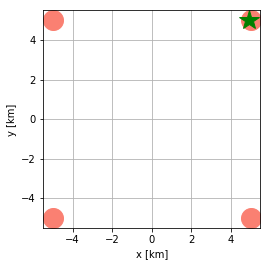

In [2]:
### create an ensemble of sources
dx=10. *1.e3 # in meters
sources=[]
sources.append(source(-dx*.5,-dx*.5))
sources.append(source(dx*.5,-dx*.5))
sources.append(source(dx*.5,dx*.5))
sources.append(source(-dx*.5,dx*.5))
Ns = len(sources)

### init a receiver
#r=receiver(0. *1.e3, 0. *1.e3, e_x=10.e3)
r=receiver(4.9 *1.e3, 5. *1.e3, e_x=10.e3)

### init mapping
pmap = xtmap(c_b=1500., e_c=10., e_min=1.e-3)  #e_min on time (Cramer-Rao)

### plot
plt.figure()
ax=plt.subplot(111)
[s.plot() for s in sources]
r.plot()
ax.grid()
ax.set_aspect('equal')
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()

In [3]:
for i, s in enumerate(sources):
    print('Distance source %d - float = %.2f km' %(i, dist(s,r)/1.e3))
    print('    - Horizontal offset for a sound celerity difference of %.1f m/s = %.2f m' %(pmap.e_c, dist(s,r)*pmap.e_c/pmap.c_b))
    print('    - Corresponding propagation time uncertainty %.2e s \n' %(dist(s,r)*pmap.e_c/pmap.c_b**2))    

Distance source 0 - float = 14.07 km
    - Horizontal offset for a sound celerity difference of 10.0 m/s = 93.81 m
    - Corresponding propagation time uncertainty 6.25e-02 s 

Distance source 1 - float = 10.00 km
    - Horizontal offset for a sound celerity difference of 10.0 m/s = 66.67 m
    - Corresponding propagation time uncertainty 4.44e-02 s 

Distance source 2 - float = 0.10 km
    - Horizontal offset for a sound celerity difference of 10.0 m/s = 0.67 m
    - Corresponding propagation time uncertainty 4.44e-04 s 

Distance source 3 - float = 9.90 km
    - Horizontal offset for a sound celerity difference of 10.0 m/s = 66.00 m
    - Corresponding propagation time uncertainty 4.40e-02 s 



**- A priori uncertainties and estimates are :**

In [4]:
# a priori uncertainties : 
print("e_c  = %.1f m/s  (celerity)" %pmap.e_c)
print("e_x  = %.1f m  (underwater float position)" %r.e_x)

e_c  = 10.0 m/s  (celerity)
e_x  = 10000.0 m  (underwater float position)


---
# 3 - Statistical simulations for 1 receiver position

For each source-receiver acoustic path, a random value of c is drawn around **c_b = 1500m/s**.
The standard deviation of the celerity is **e_c = 10 m/s**.

**- The true underwater float position and clock offset are:**

In [5]:
print('x = %.1f m \ny = %.1f m \ndt = %.1e s' %(r.x, r.y, r.dt))

x = 4900.0 m 
y = 5000.0 m 
dt = 1.4e+00 s


**- Unchanged variables during simulations are : **

In [6]:
print("s.x_t :", [s.x_t for s in sources])
print("s.y_t :", [s.y_t for s in sources])
print("s.dx  :", [s.dx for s in sources])
print("s.dy  :", [s.dy for s in sources])
print("r.dt  :", r.dt)

s.x_t : [array([-4985.69240458]), array([4997.01670242]), array([5008.73750621]), array([-5001.82312498])]
s.y_t : [array([-5004.64945267]), array([-4995.57804587]), array([5006.90623808]), array([5012.61520114])]
s.dx  : [array([14.30759542]), array([-2.98329758]), array([8.73750621]), array([-1.82312498])]
s.dy  : [array([-4.64945267]), array([4.42195413]), array([6.90623808]), array([12.61520114])]
r.dt  : [1.41587104]


**- Simulations : only celerity between receiver and each source is changing** 

In [7]:
# simple geolocation 
Nmc = 1000
x=np.zeros(Nmc)
y=np.zeros(Nmc)
dt=np.zeros(Nmc)
su=np.zeros(Nmc)

for i in range(Nmc):
    r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
    x[i], y[i], dt[i], success, message, res = geolocalize_xtmap(r, sources, pmap, clock_drift=False)

d_rms = np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) )
bias_x = x.mean()-r.x
bias_y = y.mean()-r.y
print('\nrms error, x bias, y bias: %.1fm, %.1fm, %.1fm ' %(d_rms, bias_x, bias_y))


rms error, x bias, y bias: 73.3m, 7.7m, -3.0m 


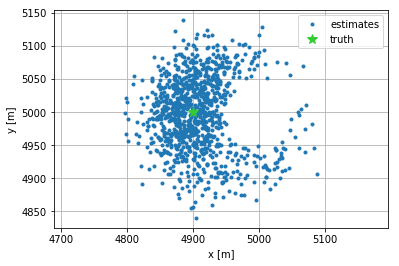

In [8]:
plt.figure()
ax=plt.subplot(111)
ax.plot(x,y,'.', label='estimates')
ax.plot(r.x,r.y,'*', color='limegreen', markersize=10, label='truth')
ax.axis('equal')
ax.grid()
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()

In [9]:
### rerun minimization with adjusted a priori estimates
Nmc = 1000
x=np.zeros(Nmc)
y=np.zeros(Nmc)
dt=np.zeros(Nmc)
su=np.zeros(Nmc)

for i in range(Nmc):
    # solve a first time
    r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
    x[i], y[i], dt[i], success, message, res = geolocalize_xtmap(r, sources, pmap, clock_drift=False)
    # rerun with adjusted expected errors on propagation time
    for j in range(1):
        x[i], y[i], dt[i], success, message, res = geolocalize_xtmap(r, sources, pmap, clock_drift=False, \
                                                                     x0=[x[i], y[i], dt[i]])

d_rms = np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) )
bias_x = x.mean()-r.x
bias_y = y.mean()-r.y
print('\nrms error, x bias, y bias: %.1fm, %.1fm, %.1fm ' %(d_rms, bias_x, bias_y))

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations

rms error, x bias, y bias: 66.9m, 22.3m, -5.5m 


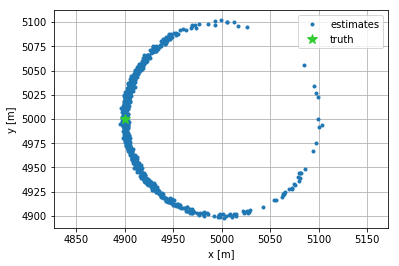

In [10]:
plt.figure()
ax=plt.subplot(111)
ax.plot(x,y,'.', label='estimates')
ax.plot(r.x,r.y,'*', color='limegreen', markersize=10, label='truth')
ax.axis('equal')
ax.grid()
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()

---
# 4 - Error map 

**- Function "simu" : simulations for one receiver position ; returns rms and bias.  **

In [22]:
def simu (r, sources, Nmc, var) : 
    x=np.zeros(Nmc)
    y=np.zeros(Nmc)
    dt=np.zeros(Nmc)
    su = np.zeros (Nmc)
    
    for i in range(Nmc):
        
        if var == 'celerity' : 
            [s.draw_celerity(s.e_c) for s in sources]
        if var == 'dxdy' : 
            [s.draw_dxdy(10.) for s in sources]
        if var == 'clock' : 
            r.draw_clock_drift()
            #dt_truth[i] = r.dt    
        
        # solve a first time
        r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
        x[i], y[i], dt[i], success, message, res = geolocalize_xtmap(r, sources, pmap, clock_drift=False)
        # rerun with adjusted expected errors on propagation time
        for j in range(1):
            x[i], y[i], dt[i], success, message, res = geolocalize_xtmap(r, sources, pmap, \
                                                                         clock_drift=False, \
                                                                         x0=[x[i], y[i], dt[i]])
        if success :
            su[i] = 1 
        elif message.find('iterations')!= -1 : 
            # "Warning: Maximum number of iterations has been exceeded."
            su[i] = -1
        elif message.find('precision loss')!= -1 :
            #Warning: Desired error not necessarily achieved due to precision loss.
            su[i] = -2
        else : 
            su[i] = -3
    
    
    # rms error on the receiver position
    d_rms = np.sqrt( np.mean( (x[np.where(su==1)] - r.x)**2  + (y[np.where(su==1)] - r.y)**2 ) )
    # biais on the receiver position
    biais_x = x[np.where(su==1)].mean()-r.x
    biais_y = y[np.where(su==1)].mean()-r.y
    #biais = np.sqrt(biais_x**2 + biais_y**2)
    return (d_rms, bias_x, bias_y, su)

**- Creation of a grid : **

In [23]:
Lx = 20.* 1.e3
Ly = Lx 
xt = np.linspace(-Lx/2.,Lx/2.,20)   # 20 values on 20km : resolution of 1km 
yt = np.linspace(-Ly/2.,Ly/2.,20)
Xt, Yt = np.meshgrid(xt,yt)

**- Calculations for each receiver position :** 

In [24]:
### number of simulations 
Nmc = 100
var = 'celerity'

In [ ]:
### map calculations
RMS = np.zeros((len(xt),len(yt)))
Bias_x = np.zeros((len(xt),len(yt)))
Bias_y = np.zeros((len(xt),len(yt)))
Success = np.zeros((Nmc, len(xt),len(yt)))
dt = r.dt
for i in range (len(xt)) :
    print('i = %d/%d' %(i+1,len(xt)))
    for j in range (len(yt)):
        # init a receiver
        r = receiver(xt[i], yt[j])
        r.dt = dt # unchanged variable during simulations 
        
        # simulations 
        d_rms, bias_x, bias_y, su = simu (r, sources, Nmc, var = var) 
        RMS[i,j]        = d_rms
        Bias_x[i,j]     = bias_x
        Bias_y[i,j]     = bias_y
        Success[:,i,j]  = su

### saving        
np.save('RMS_20_20_nodrift', RMS)
np.save('BiasX_20_20_nodrift', Bias_x)
np.save('BiasY_20_20_nodrift', Bias_y)
np.save('Success_20_20_nodrift', Success)

In [28]:
RMS1 = np.load('NPY/RMS_20_20_nodrift.npy')
BiasX1 = np.load('NPY/BiasX_20_20_nodrift.npy')
BiasY1 = np.load('NPY/BiasY_20_20_nodrift.npy')
Success1 = np.load('NPY/Success_20_20_nodrift.npy')

In [29]:
Biais1 = np.sqrt(BiasX1**2 + BiasY1**2)

In [30]:
rej = np.where(Success1 != 1)[0].size
tot = Success1.size
print("%.1f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.0% des minimisations ont échoué.


**- Plots : error map + bias map**

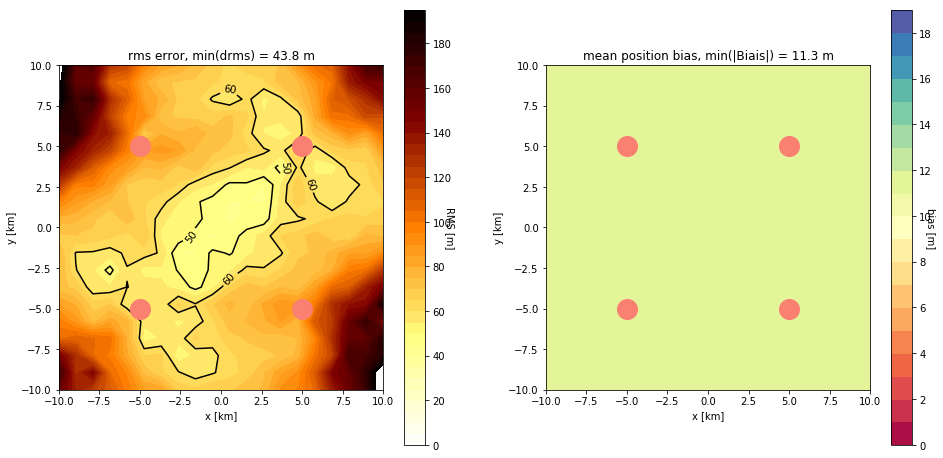

In [41]:
plt.figure(figsize=(16,8))

## error
ax=plt.subplot(121)
cmap = plt.get_cmap('afmhot_r')
lvls=np.arange(0.,2.e2,5.)
plt.contourf(Xt/1.e3,Yt/1.e3,RMS1,lvls, cmap=cmap)  #,lvls
cbar = plt.colorbar()
cbar.ax.set_ylabel('RMS [m]', rotation=270)

CS = plt.contour(Xt/1.e3,Yt/1.e3,RMS1,[50,60],colors='k')
plt.clabel(CS, [50,60],  # label every second level
           inline=1,
           fmt='%1.0f',
           fontsize=10)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('rms error, min(drms) = %.1f m' % RMS1.min())
ax.set_aspect('equal')

## bias
ax=plt.subplot(122)
cmap = plt.get_cmap('Spectral')
lvls=np.arange(0.e1,2.e1,1.e0)
plt.contourf(Xt/1.e3,Yt/1.e3, Biais1,lvls,cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_ylabel('bias [m]', rotation=270)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('mean position bias, min(|Biais|) = %.1f m' % np.abs(Biais1).min())
ax.set_aspect('equal')
plt.show()

---
# 5 - Transects

Calculations to create a map take a long time : it seems better to work with only one transect. 

**- Calculation and plot functions for transects : **

In [44]:
def transect (sources, X, Y, Nmc, var) :
    RMS_t = np.zeros((len(X)))
    BiasX_t = np.zeros((len(X)))
    BiasY_t = np.zeros((len(X)))
    Success_t = np.zeros((Nmc, len(X)))
    for i in range (len(X)) :
        # init a receiver
        r = receiver(X[i], Y)
        r.dt = 1. # unchanged variable during simulations 
        #
        d_rms, bias_x, bias_y, su = simu (r, sources, Nmc, var = var)

        RMS_t[i]       = d_rms
        BiasX_t[i]     = bias_x
        BiasY_t[i]     = bias_y
        Success_t[:,i] = su
    return RMS_t, BiasX_t, BiasY_t, Success_t


def plot_transect (sources, X, Y, RMS_t, Biais_t):
    print('min (rms) = %.1f m' %np.min(RMS_t))
    print('min (bias) = %.1f m' %np.min(Biais_t))
    plt.figure(figsize=(17,4))
    # plot sources 
    ax=plt.subplot(131)
    [s.plot() for s in sources]
    plt.title ('sources and transect')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
    ax.grid()
    #ax.set_xlim([np.min(X)/1000.,np.max(X)/1000.])
    ax.set_ylim([-abs(sources[0].y_s)/1000. - 5., abs(sources[0].y_s)/1000. + 5.])
    ax.set_aspect('equal')
    plt.plot([np.min(X)/1000.,np.max(X)/1000.],[Y/1000.,Y/1000.],'.-b')

    ## plot rms result
    ax2 = plt.subplot(132)
    ax2.grid()
    plt.plot(X/1.e3, RMS_t, '.') 
    plt.xlabel('x [km]')
    plt.ylabel('RMS [m]')
    plt.title('RMS error along the transect Y=%.dkm' %int(Y/1000.))
    
    ## plot bias
    ax3  = plt.subplot(133)
    ax3.grid()
    plt.plot(X/1.e3, Biais_t, '.')
    plt.xlabel('x [km]')
    plt.ylabel('Bias [m]')
    plt.title('Bias along the transect Y=%.dkm' %int(Y/1000.))
    
    plt.show()

**- Creation of a transect : **

In [45]:
L = 40.* 1.e3
X = np.linspace(-L/2.,L/2.,200)  # resolution : 200m
Y = 0. 

**A - Distance between sources : 10km, with Y=0 km **

In [ ]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, BiasY_t, Success_t = transect (sources, X, Y, Nmc, var)

np.save('RMS_t_nodrift', RMS_t)
np.save('BiasX_t_nodrift', BiasX_t)
np.save('BiasY_t_nodrift', BiasY_t)
np.save('Success_t_nodrift', Success_t)

In [50]:
RMS_t     = np.load('NPY/RMS_t_nodrift.npy')
BiasX_t   = np.load('NPY/BiasX_t_nodrift.npy')
BiasY_t   = np.load('NPY/BiasY_t_nodrift.npy')
Success_t = np.load('NPY/Success_t_nodrift.npy')

min (rms) = 43.4 m
min (bias) = 11.3 m


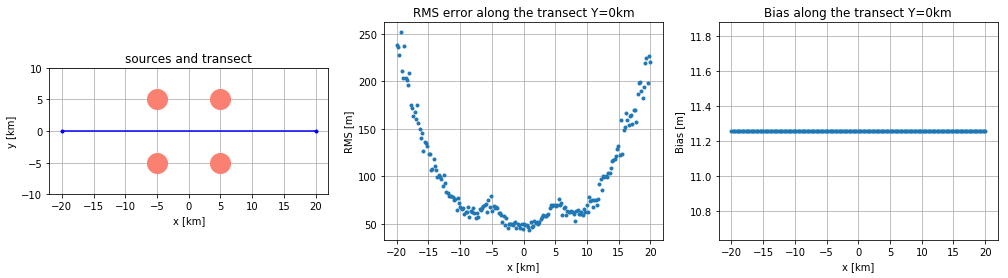

In [51]:
Biais_t = np.sqrt(BiasX_t**2 + BiasY_t**2)
plot_transect(sources, X, Y, RMS_t, Biais_t)

In [52]:
rej = np.where(Success_t != 1)[0].size
tot = Success_t.size
print("%.1f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.0% des minimisations ont échoué.


---
**B - Same distance, with Y=5 km **

In [53]:
Y = 5000.

In [ ]:
RMS_t5, BiasX_t5, BiasY_t5, Success_t5 = transect (sources, X, Y, Nmc, var)

np.save('RMS_t5_nodrift', RMS_t5)
np.save('BiasX_t5_nodrift', BiasX_t5)
np.save('BiasY_t5_nodrift', BiasY_t5)
np.save('Success_t5_nodrift', Success_t5)

In [56]:
RMS_t5     = np.load('NPY/RMS_t5_nodrift.npy')
BiasX_t5   = np.load('NPY/BiasX_t5_nodrift.npy')
BiasY_t5   = np.load('NPY/BiasY_t5_nodrift.npy')
Success_t5 = np.load('NPY/Success_t5_nodrift.npy')

min (rms) = 50.3 m
min (bias) = 11.3 m


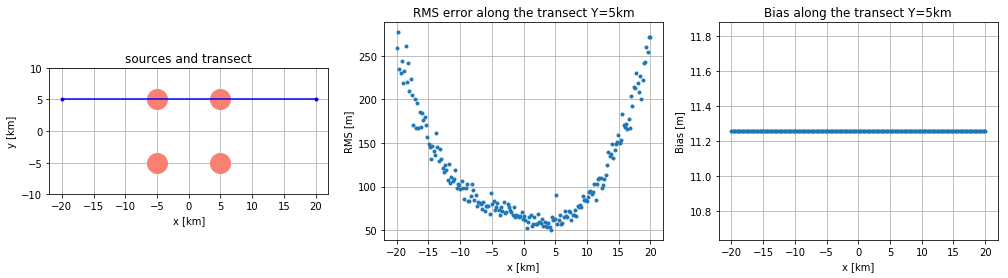

In [57]:
Biais_t5 = np.sqrt(BiasX_t5**2 + BiasY_t5**2)
plot_transect(sources, X, Y, RMS_t5, Biais_t5)

In [58]:
rej = np.where(Success_t5 != 1)[0].size
tot = Success_t5.size
print("%.1f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.0% des minimisations ont échoué.


---
**C - Distance between sources : 20km **

In [60]:
Y = 0.

In [61]:
dx=20. *1.e3 # in meters
sources=[]
sources.append(source(-dx*.5,-dx*.5))
sources.append(source(dx*.5,-dx*.5))
sources.append(source(dx*.5,dx*.5))
sources.append(source(-dx*.5,dx*.5))
Ns = len(sources)

In [ ]:
RMS_t20km, BiasX_t20km, BiasY_t20km, Success_t20km = transect (sources, X, Y, Nmc, var)

np.save('RMS_t20km_nodrift', RMS_t20km)
np.save('BiasX_t20km_nodrift', BiasX_t20km)
np.save('BiasY_t20km_nodrift', BiasY_t20km)
np.save('Success_t20km_nodrift', Success_t20km)

In [68]:
RMS_t20km     = np.load('NPY/RMS_t20km_nodrift.npy')
BiasX_t20km   = np.load('NPY/BiasX_t20km_nodrift.npy')
BiasY_t20km   = np.load('NPY/BiasY_t20km_nodrift.npy')
Success_t20km = np.load('NPY/Success_t20km_nodrift.npy')

In [69]:
rej = np.where(Success_t20km != 1)[0].size
tot = Success_t20km.size
print("%.2f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.01% des minimisations ont échoué.


min (rms) = 85.0 m
min (bias) = 11.3 m


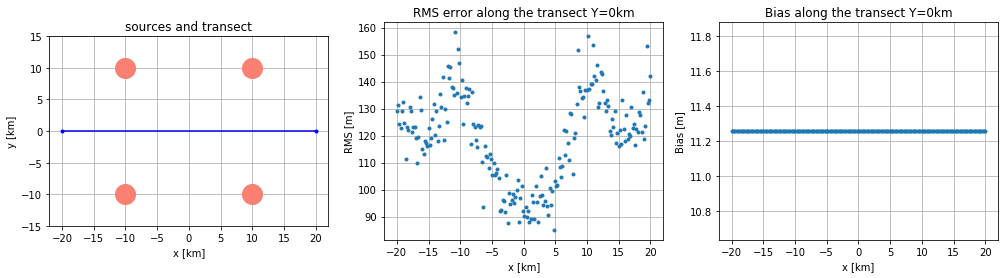

In [70]:
Biais_t20km = np.sqrt(BiasX_t20km**2 + BiasY_t20km**2)
plot_transect(sources, X, Y, RMS_t20km, Biais_t20km)

---
**D - With 5 sources (one on the center) **

In [71]:
# 5th source added
sources.append(source(0.,0.))
Ns = len(sources)

In [ ]:
RMS_t20_5sources, BiasX_t20_5sources, BiasY_t20_5sources, Success_t20_5sources = transect (sources, X, Y, Nmc, var)

np.save('RMS_t20km_5s_nodrift', RMS_t20_5sources)
np.save('BiasX_t20km_5s_nodrift', BiasX_t20_5sources)
np.save('BiasY_t20km_5s_nodrift', BiasY_t20_5sources)
np.save('Success_t20km_5s_nodrift', Success_t20_5sources)

In [73]:
RMS_t20_5sources     = np.load('NPY/RMS_t20km_5s_nodrift.npy')
BiasX_t20_5sources   = np.load('NPY/BiasX_t20km_5s_nodrift.npy')
BiasY_t20_5sources   = np.load('NPY/BiasY_t20km_5s_nodrift.npy')
Success_t20_5sources = np.load('NPY/Success_t20km_5s_nodrift.npy')

In [76]:
rej = np.where(Success_t20_5sources != 1)[0].size
tot = Success_t20_5sources.size
print("%.1f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.0% des minimisations ont échoué.


min (rms) = 55.9 m
min (bias) = 11.3 m


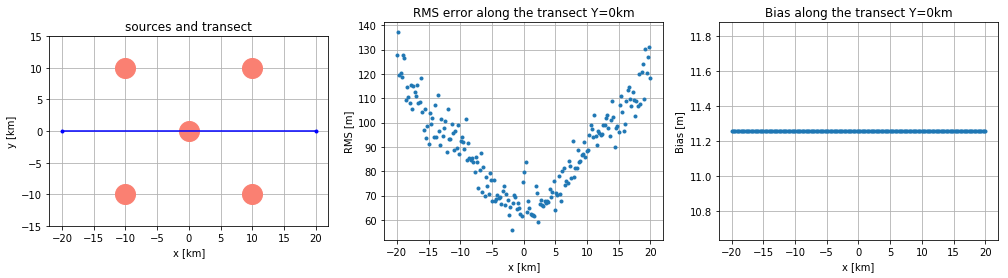

In [77]:
Biais_t20_5sources = np.sqrt(BiasX_t20_5sources**2 + BiasY_t20_5sources**2)
plot_transect(sources, X, Y, RMS_t20_5sources, Biais_t20_5sources)

---
**E - Y = 5km - 5 sources**

In [79]:
Y=5000.

In [ ]:
RMS_y5_5sources, BiasX_y5_5sources, BiasY_y5_5sources, Success_y5_5sources = transect (sources, X, Y, Nmc, var)

np.save('RMS_y5_5sources', RMS_y5_5sources)
np.save('BiasX_y5_5sources', BiasX_y5_5sources)
np.save('BiasY_y5_5sources', BiasY_y5_5sources)
np.save('Success_y5_5sources', Success_y5_5sources)

In [83]:
RMS_y5_5sources     = np.load('NPY/RMS_y5_5sources_nodrift.npy')
BiasX_y5_5sources   = np.load('NPY/BiasX_y5_5sources_nodrift.npy')
BiasY_y5_5sources   = np.load('NPY/BiasY_y5_5sources_nodrift.npy')
Success_y5_5sources = np.load('NPY/Success_y5_5sources_nodrift.npy')

In [86]:
rej = np.where(Success_y5_5sources != 1)[0].size
tot = Success_y5_5sources.size
print("%.1f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.0% des minimisations ont échoué.


min (rms) = 61.0 m
min (bias) = 11.3 m


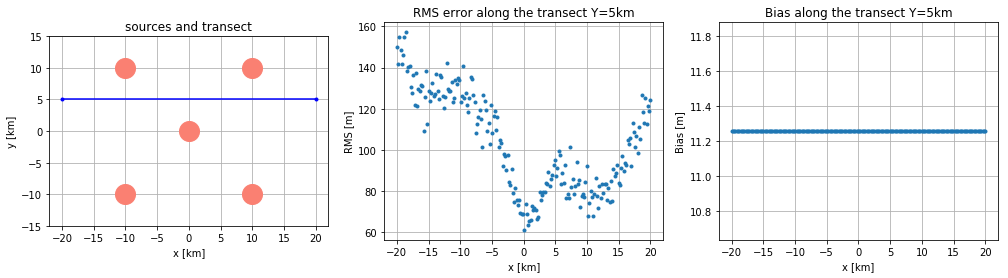

In [88]:
Biais_y5_5sources = np.sqrt(BiasX_y5_5sources**2 + BiasY_y5_5sources**2)
plot_transect(sources, X, Y, RMS_y5_5sources, Biais_y5_5sources)

In [ ]:
### tableau des minimums de RMS et biais suivant les config ??